In some of my previous strategies, I have noted that the backtest did not account for survivorship bias. [Survivorship bias](https://en.wikipedia.org/wiki/Survivorship_bias) is a form of selection bias caused by only focusing on assets that passed some sort of selection process.

A simple example would be a strategy that simply buys and holds an equal allocation of the current S&P 500 constituents. We can use the S&P 500 data from a [previous post](/2019/04/backtesting-a-cross-sectional-mean-reversion-strategy-in-python). We can then compare the performance of this strategy to that of RSP, an ETF that tracks the S&P 500 Equal Weight Index: 

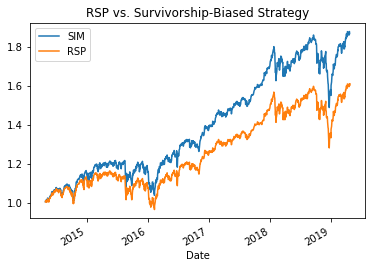

In [22]:
import pandas as pd
import pandas_datareader.data as web
%matplotlib inline

tickers = pd.read_csv('spy/tickers.csv', header=None)[1].tolist()

# calculate cumulative product of the mean of all daily returns
# i.e. simulate growth of $1 by equally weighting all current S&P 500
# constituents
sim_rsp = (
    (pd.concat(
        [pd.read_csv(f"spy/{ticker}.csv", index_col='date', parse_dates=True)[
            'close'
        ].pct_change()
        for ticker in tickers],
        axis=1,
        sort=True,
    ).mean(axis=1, skipna=True) + 1)
    .cumprod()
    .rename("SIM")
)

# download actual RSP data
rsp = (
    (web.DataReader("RSP", "yahoo", sim_rsp.index[0], sim_rsp.index[-1])[
        "Adj Close"
    ].pct_change() + 0.002 / 252 + 1)  # 0.20% annual ER
    .cumprod()
    .rename("RSP")
)

sim_rsp.plot(legend=True, title="RSP vs. Survivorship-Biased Strategy")
rsp.plot(legend=True);

Wow! If we started trading this strategy in 2014 we would have easily beat the market. We only need to know the constituents of the S&P 500 5 years in the future... This simple example shows how a trader can be tricked into thinking they have a good strategy because they have not accounted for selection bias.

# Survivorship Bias-Free Data

How do we prevent survivorship bias? It is easier said then done. In order to create a survivorship bias free data set of the S&P 500, we have to first know all of the historical constituents of the S&P 500 across our desired timeframe. Once we know all the constituents we can piece together a dataset using the historical price data of all the constituents during the time period they were in the S&P 500.

Unfortunately their are a few road blocks that make this data collection more difficult than one might expect. First of all, obtaining historical constituent data for the S&P 500 is hard. Current constituents can be scraped from [Wikipedia](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies), but finding historical constituents is near impossible without buying data. Second, once you know the historical constituents, finding pricing data can be difficult as well. Companies in the S&P 500 are continuously being renamed, being acquired, and some even going bankrupt. Free data sources like [Yahoo Finance](https://finance.yahoo.com/) usually do not have data on delisted stocks, historical ticker name changes are not well documented.  

## Data Sources

### Constituents

While we don't have real historical constituent data, we can make a close approximation using the portfolio of an S&P 500 tracking ETF. The [iShares Core S&P 500 ETF (IVV)](https://www.ishares.com/us/products/239726/) discloses its holdings every month, and claims to invest at least 90% of its assets in securities in the index. With a little web scraping we can easily get its monthly holdings since 2006:

In [43]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import json

# request page
html = requests.get("https://www.ishares.com/us/products/239726/#tabsAll").content
soup = BeautifulSoup(html)

# find available dates
holdings = soup.find("div", {"id": "holdings"})
dates_div = holdings.find_all("div", "component-date-list")[1]
dates_div.find_all("option")
dates = [option.attrs["value"] for option in date_list_div.find_all("option")]

# download constituents for each date
constituents = pd.Series()
for date in dates:
    resp = requests.get(
        f"https://www.ishares.com/us/products/239726/ishares-core-sp-500-etf/1467271812596.ajax?tab=all&fileType=json&asOfDate={date}"
    ).content[3:]
    tickers = json.loads(resp)
    tickers = [(arr[0], arr[1]) for arr in tickers['aaData']]
    date = datetime.strptime(date, "%Y%m%d")
    constituents[date] = tickers

constituents = constituents.iloc[::-1] # reverse into cronlogical order
constituents.head()

2006-09-29    [(PMCS, PMC-SIERRA INC.), (ANDW, ANDREW CORP.)...
2006-10-31    [(PMCS, PMC-SIERRA INC.), (PGL, PEOPLES ENERGY...
2006-11-30    [(PMCS, PMC-SIERRA INC.), (ADCT, ADC TELECOMMU...
2006-12-29    [(PMCS, PMC-SIERRA INC.), (ADCT, ADC TELECOMMU...
2007-01-31    [(PMCS, PMC-SIERRA INC.), (PGL, PEOPLES ENERGY...
dtype: object

As we can see for each month (only 5 shown) we have a list of all tickers and company names held in the ETF. Now that thats done we can move on to the price data.

### Price Data

As mentioned earlier, finding data for all of the constituents can be difficult. Lucky for us, Quandl's [WIKI Prices Dataset](https://www.quandl.com/databases/WIKIP/documentation) contains *most* of the data we need. Though the data feed is no longer updated, it still contains accurate data from before April 2018. We can export the data [here](https://www.quandl.com/databases/WIKIP/usage/export) after creating a free account. After we download it we can separate the data by ticker.

In [28]:
wiki = pd.read_csv("WIKI_PRICES.csv", parse_dates=True)
wiki = dict(tuple(wiki.groupby('ticker')))
for ticker in wiki:
    wiki[ticker].set_index("date", inplace=True)

Although the WIKI dataset has most of the data we need, it does not have all of it. We will use Yahoo finance to download the remaining data. Lets write some helper functions to help us download the data:

In [47]:
import time
import re

def quandl_data(ticker, start, end):
    if ticker in wiki:
        df = wiki[ticker][start:end]
    else:
        ticker = fix_ticker(ticker)
        if ticker in wiki:
            df = wiki[ticker][start:end]
        else:
            return None
    df = df.drop(['open','high','low','close', 'volume','ex-dividend','split_ratio', 'ticker'], axis=1)
    df = df.rename(index=str, columns={"adj_open": "open",
                                       "adj_high": "high",
                                       "adj_low": "low",
                                       "adj_close": "close",
                                       "adj_volume": "volume"})
    return df

def yahoo_data(ticker, start, end):
    ticker = fix_ticker(ticker)
    try:
        df = web.DataReader(ticker, "yahoo", start, end)
    except:
        time.sleep(1)
        try:
            df = web.DataReader(ticker, "yahoo", start, end)
        except:
            return None
    # adjust ohlc using adj close
    adjfactor = df["Close"] / df["Adj Close"]
    df["Open"] /= adjfactor
    df["High"] /= adjfactor
    df["Low"] /= adjfactor
    df["Close"] = df["Adj Close"]
    df["Volume"] *= adjfactor
    df = df.drop(["Adj Close"], axis=1)
    df = df.rename(str.lower, axis='columns')
    df.index.rename('date', inplace=True)
    return df

def fix_ticker(ticker):
    rename_table = {
        "-": "LPRAX", # BlackRock LifePath Dynamic Retirement Fund
        "8686": "AFL", # AFLAC
        "4XS": "ESRX", # Express Scripts Holding Company 
        "AAZ": "APC", # Anadarko Petroleum Corporation
        "AG4": "AGN", # Allergan plc
        "BFB": "BF_B", # Brown-Forman Corporation
        "BF.B": "BF_B", # Brown-Forman Corporation
        "BF/B": "BF_B", # Brown-Forman Corporation
        "BLD WI": "BLD", # TopBuild Corp.
        "BRKB": "BRK_B", # Berkshire Hathaway Inc.
        "CC WI": "CC", # The Chemours Company
        "DC7": "DFS", # Discover Financial Services
        "GGQ7": "GOOG", # Alphabet Inc. Class C
        "HNZ": "KHC", # The Kraft Heinz Company
        "LOM": "LMT", # Lockheed Martin Corp.
        "LTD": "LB", # L Brands Inc.
        "LTR": "L", # Loews Corporation
        "MPN": "MPC", # Marathon Petroleum Corp.
        "MWZ": "MET", # Metlife Inc.
        "MX4A": "CME", # CME Group Inc.
        "NCRA": "NWSA", # News Corporation
        "NTH": "NOC", # Northrop Grumman Crop.
        "PA9": "TRV", # The Travelers Companies, Inc.
        "QCI": "QCOM", # Qualcomm Inc.
        "RN7": "RF", # Regions Financial Corp
        "SLBA": "SLB", # Schlumberger Limited
        "SYF-W": "SYF", # Synchrony Financial
        "SWG": "SCHW", # The Charles Schwab Corporation 
        "UAC/C": "UAA", # Under Armour Inc Class A
        "UBSFT": "UBSFY", # Ubisoft Entertainment
        "USX1": "X", # United States Steel Corporation
        "UUM": "UNM", # Unum Group
        "VISA": "V", # Visa Inc 
    }
    if ticker in rename_table:
        fix = rename_table[ticker]
    else:
        fix = re.sub(r'[^A-Z]+', '', ticker)
    return fix

You'll notice I created a big dictionary `rename_table`. As mentioned before, companies will occasionally change their ticker, and it is often not well documented. I ended up manually creating this map of old to new names, which does add a component of human error.

## Compiling Data

Now we are ready to compile all the data using our constituents list! We will also keep track of stocks we couldn't download in `skips`.

In [48]:
data = {}
skips = set()

constituents = constituents['2013-02-28':'2018-02-28']

for i in range(0, len(constituents) - 1):
    start = str(constituents.index[i].date())
    end = str((constituents.index[i + 1].to_pydatetime() - timedelta(days=1)).date())
    for company in constituents[i]:
        if company in skips:
            continue
        df = quandl_data(company[0], start, end)
        if df is None:
            df = yahoo_data(company[0], start, end)
        if df is None:
            skips.add(company)
            continue
        if company[0] in data:
            data[company[0]] = data[company[0]].append(df)
        else:
            data[company[0]] = df

Lets take a look at the data we had to skip:

In [49]:
skips

{('ACT', 'ACTAVIS INC.'),
 ('ACT', 'ACTAVIS PLC'),
 ('BLKFDS', 'BLK CSH FND TREASURY SL AGENCY'),
 ('BMC', 'BMC SOFTWARE INC.'),
 ('CVH', 'COVENTRY HEALTH CARE INC'),
 ('ESH5', 'S&P500 EMINI MAR 15'),
 ('ESH6', 'S&P500 EMINI MAR 16'),
 ('ESH7', 'S&P500 EMINI MAR 17'),
 ('ESH8', 'S&P500 EMINI MAR 18'),
 ('ESM5', 'S&P500 EMINI JUN 15'),
 ('ESM6', 'S&P500 EMINI JUN 16'),
 ('ESM7', 'S&P500 EMINI JUN 17'),
 ('ESU5', 'S&P500 EMINI SEP 15'),
 ('ESU6', 'S&P500 EMINI SEP 16'),
 ('ESU7', 'S&P500 EMINI SEP 17'),
 ('ESZ4', 'S&P500 EMINI DEC 14'),
 ('ESZ5', 'S&P500 EMINI DEC 15'),
 ('ESZ6', 'S&P500 EMINI DEC 16'),
 ('ESZ7', 'S&P500 EMINI DEC 17'),
 ('HAWKB', 'BLACKHAWK NETWORK HOLDINGS INC CLA'),
 ('MARGIN_USD', 'FUTURES USD MARGIN BALANCE'),
 ('MOLX', 'MOLEX INC.'),
 ('NYX', 'NYSE EURONEXT'),
 ('PCS', 'METROPCS COMMUNICATIONS INC.'),
 ('UBFUT', 'CASH COLLATERAL USD UBFUT')}

As we can see there are a few companies that we could not get data for because they have since been acquired. It may be possible find the data from a different source, but lets keep what we have so far. In addition, we notice that the ETF occasionally held S&P 500 futures as well as cash collateral, which is part of the <10% of holdings not in the index.

## Exporting

Now we can export our data back into csv:

In [52]:
for ticker, df in data.items():
    df = df.reset_index().drop_duplicates(subset='date').set_index('date')
    df.to_csv(f"survivorship-free/{fix_ticker(ticker)}.csv")
    data[ticker] = df
tickers = [fix_ticker(ticker) for ticker in data.keys()]
pd.Series(tickers).to_csv("survivorship-free/tickers.csv")

# Testing

Now that we have our survivorship bias free data, lets test it against the equal weight S&P 500 ETF RSP used in the first section:

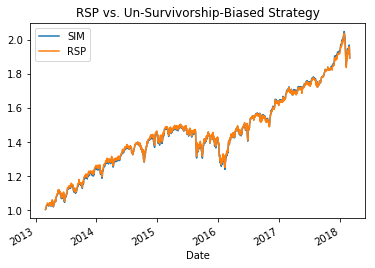

In [56]:
sim_rsp = (
    (pd.concat(
        [pd.read_csv(f"survivorship-free/{ticker}.csv", index_col='date', parse_dates=True)[
            'close'
        ].pct_change()
        for ticker in tickers],
        axis=1,
        sort=True,
    ).mean(axis=1, skipna=True) + 1)
    .cumprod()
    .rename("SIM")
)

rsp = (
    (web.DataReader("RSP", "yahoo", sim_rsp.index[0], sim_rsp.index[-1])[
        "Adj Close"
    ].pct_change() + 0.002 / 252 + 1)  # 0.20% annual ER
    .cumprod()
    .rename("RSP")
)

sim_rsp.plot(legend=True, title="RSP vs. Un-Survivorship-Biased Strategy")
rsp.plot(legend=True);

The lines are near identical! Although my dataset is not 100% historically accurate, it is definitely a much better start than just using current S&P 500 constituents. Best of all, it only uses free data, and you can download it from my GITHUB LINK HERE. 